# Detecting Pigs and the Swedish Chef based on audio and visual features

This notebook documents our approach to detect Pigs and the Swedish Chef based on feature-engineering for both modalities.  
We employ a Gaussian Mixture Model Classifier to predict the characters based on different video and audio-engineering features used for the different characters.

## Time sheet for this notebook

**Daniel Blasko:**

<table>
<thead>
  <tr>
    <th>Date</th>
    <th>Task</th>
    <th>Hours</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td>09.01.2024</td>
    <td>Setup notebook structure, load audio data and prepare the classifier - make the notebook ready so that only merging visual features is missing.</td>
    <td>2</td>
  </tr>
  <tr>
    <td>09.01.2024</td>
    <td>Experiment with Gaussian Mixture Models.</td>
    <td>2</td>
  </tr>
  <tr>
    <td>11.01.2024</td>
    <td>Work session together with Alina to integrate her features in the notebook.</td>
    <td>1</td>
  </tr>
</tbody>
</table>

**Alina Ehart:**

<table>
<thead>
  <tr>
    <th>Date</th>
    <th>Task</th>
    <th>Hours</th>

  </tr>
</thead>
<tbody>
  
</tbody>
</table>


## Imports


In [ ]:
!pip install -r ../requirements.txt


In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    average_precision_score,
    accuracy_score,
)
from sklearn.mixture import GaussianMixture


import sys

sys.path.append("..")
from utils.visual_evaluation import (
    plot_confusion_matrix,
    plot_roc_curve,
    plot_precision_recall_curve,
    plot_global_confusion_matrix,
)


## Loading both sets of features and merging them into one dataframe


In each notebook for audio/vision, we have created a dataframe with the features fed into the classifier and exported it as a csv file. We will now load both csv files and merge them into one dataframe for the hybrid classifier.


In [3]:
vision_df = pd.read_csv("../results/sim2_visual/all.csv")


In [4]:
audio_df = pd.read_csv("../results/sim2_visual/all.csv")
# TODO: remove two following rows once we have the audio features, this is temporary to test the notebook
audio_df["Audio_Pigs"] = vision_df["Pigs"]
audio_df["Audio_Cook"] = vision_df["Cook"]
audio_df.drop(columns=["Pigs", "Cook"], inplace=True)


In [5]:
dataset = audio_df.merge(vision_df, on=["video_idx", "frame_idx"], how="inner")


Sanity check:


In [6]:
assert dataset.shape[0] == audio_df.shape[0] == vision_df.shape[0]
# TODO: check for _y and _x columns once vision dataset is available - should only be one Kermit column for example!!!


## Splitting the data and aggregating the labels


For the hybrid classifier, we want to detect if the character is present at a given frame whether it is through audio or visual features. Therefore, we will aggregate the labels for each frame by merging the visual and audio flags (when both are available, which is not the case for Kermit) into a single one.


In [7]:
dataset["Pigs"] = dataset["Pigs"] + dataset["Audio_Pigs"]
dataset["Cook"] = dataset["Cook"] + dataset["Audio_Cook"]
# TODO: test once we have data
dataset["Pigs"].replace(2, 1, inplace=True)
dataset["Cook"].replace(2, 1, inplace=True)
dataset.drop(columns=["Audio_Pigs", "Audio_Cook"], inplace=True)


And then split our data and prepare it for the classifier:


In [8]:
RANDOM_SPLIT = True  # Change this boolean to experiment with one option or another


In [46]:
# We extract the `X` and `y` matrices for the model, and then split into train and test sets by a 80/20 ratio
X = dataset.drop(columns=["Pigs", "Cook", "video_idx", "frame_idx"])
X.fillna(0, inplace=True)
y = dataset[["Pigs", "Cook"]]


In [47]:
if RANDOM_SPLIT:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
else:
    X_train = X.head(int(X.shape[0] * 0.8))
    X_test = X.tail(int(X.shape[0] * 0.2))
    y_train = y.head(int(y.shape[0] * 0.8))
    y_test = y.tail(int(y.shape[0] * 0.2))

assert X.shape[0] == X_train.shape[0] + X_test.shape[0]
assert y.shape[0] == y_train.shape[0] + y_test.shape[0]


Converting the one-hot-encoded labels into a single class column:  
Right now, the `y` matrix one-hot encodes the labels, but we need to convert it to a single column of labels for the classifier, where:

- 0: neither pigs nor the Swedish chef are present
- 1: Pigs are present
- 2: The Swedish chef is present
- 3: both are present


In [48]:
# TODO: check y_train before to verify right ordering of cols!!!
y_train = np.argmax(y_train, axis=1) + np.any(y_train, axis=1)
y_test = np.argmax(y_test, axis=1) + np.any(y_test, axis=1)


## Training the classifier


Initially, to use a complex classifier from the Sim2 lectures, we implemented a Gaussian Mixture Model Classifier. However, the performance of the model was poor. We therefore decided to leave the working implementation to show that we worked on the Gaussian Mixture Models, but use a Quadratic Discriminant Analysis Classifier for evaluation.

The following cell shows our implementation of Gaussian Mixture Models for this task: we train a GMM for each class (stored in `gmms`) and then predict the class with the highest probability for each frame, as implemented below. Our hypothesis is that they did not perform well because the features are not normally distributed, which is an assumption of the GMM classifier, and since in this setting we have a very large feature vector, the important features might be overshadowed by the less important ones in this setting.


In [40]:
# Create a GMM for each class
gmms = [
    GaussianMixture(n_components=2, reg_covar=1e-4, covariance_type="full").fit(
        X_train[y_train == i]
    )
    for i in range(3)
]


# Prediction function
def predict_gmm(data_point, gmms):
    scores = np.array([gmm.score_samples([data_point]) for gmm in gmms])
    return np.argmax(scores)


# Example prediction
new_data_point = X_test.iloc[0]
predicted_class = predict_gmm(new_data_point, gmms)
print(f"Predicted class for the data point is: {predicted_class} real is {y_test[0]}")


Predicted class for the data point is: 2 real is 0


/Users/daniel/miniforge3/envs/simmod/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
/Users/daniel/miniforge3/envs/simmod/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
/Users/daniel/miniforge3/envs/simmod/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(


For the reasons explained above, for the final hybrid classifier, we decide to use a quadratic discriminant analysis classifier in addition to the gaussian mixture model classifier that will take features from both modalities as an input. Its hyperparameters will be tuned through grid search and cross-validation.


In [ ]:
param_grid = {
    "reg_param": [0, 0.1, 0.3],
    "tol": [1e-3, 1e-4, 1e-5],
}
grid_search = GridSearchCV(
    QuadraticDiscriminantAnalysis(),
    param_grid,
    cv=3,
    scoring="recall_weighted",
)  # We optimize for recall because in experiments, false negatives were the biggest problem
grid_search.fit(X_train, y_train)
best_lr = grid_search.best_estimator_
print(grid_search.best_params_)
y_pred = best_lr.predict(X_test)


## Evaluating the classifier


In [50]:
# Convert labels for the first character
y_test_pigs = (y_test == 1) | (y_test == 3)
y_pred_pigs = (y_pred == 1) | (y_pred == 3)

# Convert labels for the second character
y_test_cook = (y_test == 2) | (y_test == 3)
y_pred_cook = (y_pred == 2) | (y_pred == 3)


# Compute metrics for the first character
accuracy_pigs = accuracy_score(y_test_pigs, y_pred_pigs)
precision_pigs = precision_score(y_test_pigs, y_pred_pigs)
recall_pigs = recall_score(y_test_pigs, y_pred_pigs)
f1_pigs = f1_score(y_test_pigs, y_pred_pigs)
map_pigs = average_precision_score(y_test_pigs, y_pred_pigs)

# Compute metrics for the second character
accuracy_cook = accuracy_score(y_test_cook, y_pred_cook)
precision_cook = precision_score(y_test_cook, y_pred_cook)
recall_cook = recall_score(y_test_cook, y_pred_cook)
f1_cook = f1_score(y_test_cook, y_pred_cook)
map_cook = average_precision_score(y_test_cook, y_pred_cook)

# Compute metrics for the general classifier as a whole
accuracy_general = accuracy_score(y_test, y_pred)
precision_general = precision_score(y_test, y_pred, average="weighted")
recall_general = recall_score(y_test, y_pred, average="weighted")
f1_general = f1_score(y_test, y_pred, average="weighted")


***General model metrics***
	Accuracy: 0.8666350261034647
	Precision: 0.8984048686568675
	Recall: 0.8666350261034647
	F1: 0.8752079785125171
***Pigs***
	Accuracy: 0.868101997670104
	Precision: 0.6011324315822586
	Recall: 0.8800368408933916
	F1: 0.7143257639472947
	MAP: 0.5514978679958342
***Swedish chef***
	Accuracy: 0.9980584199853303
	Precision: 0.9931623931623932
	Recall: 0.9340836012861736
	F1: 0.9627174813587407
	MAP: 0.9294656999915997


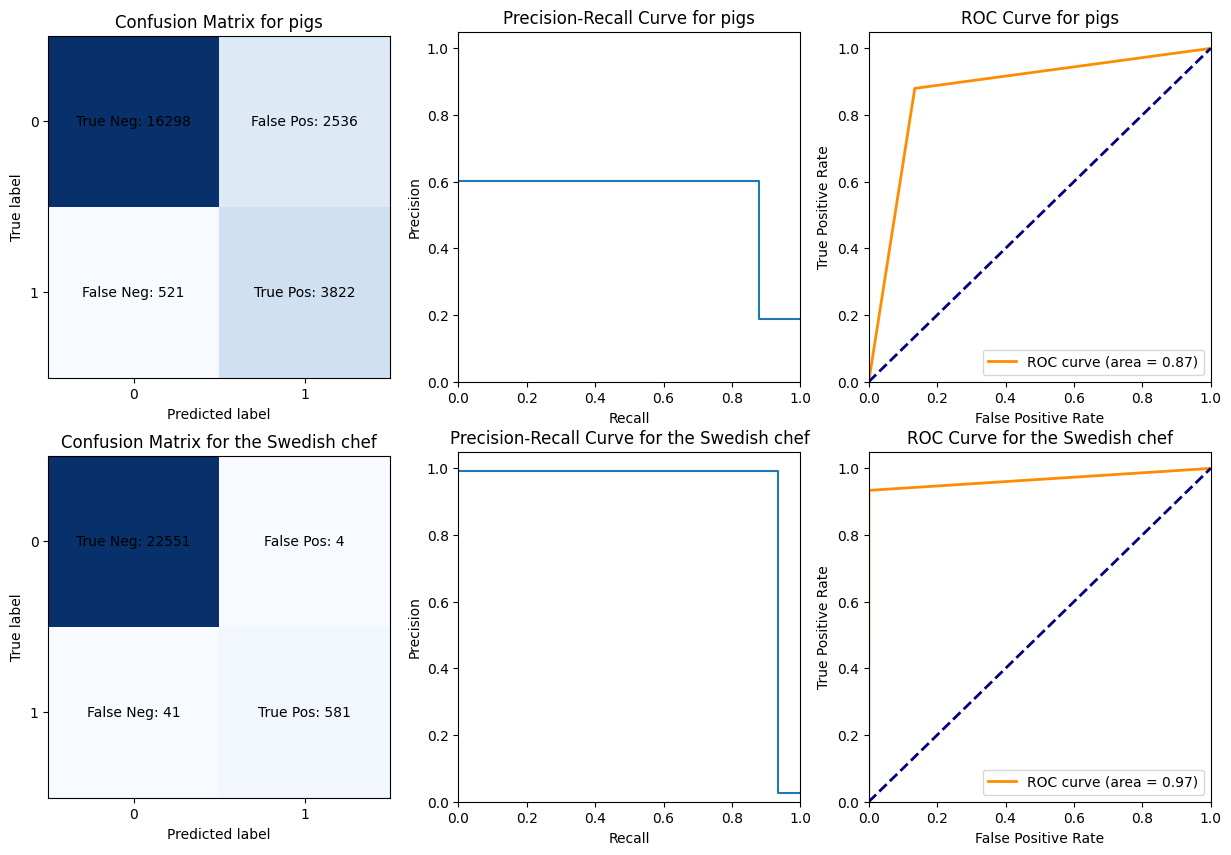

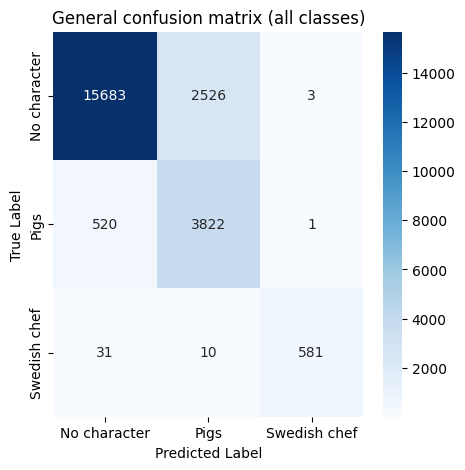

In [51]:
# *** Metrics ***
print(
    f"***General model metrics***\n\tAccuracy: {accuracy_general}\n\tPrecision: {precision_general}\n\tRecall: {recall_general}\n\tF1: {f1_general}"
)
print(
    f"***Pigs***\n\tAccuracy: {accuracy_pigs}\n\tPrecision: {precision_pigs}\n\tRecall: {recall_pigs}\n\tF1: {f1_pigs}\n\tMAP: {map_pigs}"
)
print(
    f"***Swedish chef***\n\tAccuracy: {accuracy_cook}\n\tPrecision: {precision_cook}\n\tRecall: {recall_cook}\n\tF1: {f1_cook}\n\tMAP: {map_cook}"
)

# *** Visual evaluation ***
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
# Pigs
plot_confusion_matrix(
    y_test_pigs, y_pred_pigs, "Confusion Matrix for pigs", ax=axs[0, 0]
)
plot_precision_recall_curve(
    y_test_pigs, y_pred_pigs, "Precision-Recall Curve for pigs", ax=axs[0, 1]
)
plot_roc_curve(y_test_pigs, y_pred_pigs, "ROC Curve for pigs", ax=axs[0, 2])
# Swedish chef
plot_confusion_matrix(
    y_test_cook,
    y_pred_cook,
    "Confusion Matrix for the Swedish chef",
    ax=axs[1, 0],
)
plot_precision_recall_curve(
    y_test_cook,
    y_pred_cook,
    "Precision-Recall Curve for the Swedish chef",
    ax=axs[1, 1],
)
plot_roc_curve(y_test_cook, y_pred_cook, "ROC Curve for the Swedish chef", ax=axs[1, 2])
fig, axs = plt.subplots(1, 1, figsize=(5, 5))
plot_global_confusion_matrix(
    y_test,
    y_pred,
    "Pigs",
    "Swedish chef",
)


## Analysis of the results


TODO:
